In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np 
import torch 
torch.set_default_dtype(torch.float64)

import rascaline.torch

import metatensor.torch as mts

from metatensor.torch import Labels, TensorBlock, TensorMap
from metatensor.learn import IndexedDataset, DataLoader
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts

from mlelec.data.dataset import QMDataset, split_by_Aij_mts
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase, kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm, plot_block_errors
from mlelec.features.acdc import compute_features
from mlelec.utils.target_utils import get_targets
from mlelec.models.linear import LinearModelPeriodic
from mlelec.metrics import L2_loss, L2_loss_meanzero
import xitorch
from xitorch.linalg import symeig

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
device = 'cuda'

orbitals = {
    'sto-3g': {5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]}, 
    
    'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
    'benzene': {6: [[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 1:[[1,0,0]]},
    'gthszvmolopt': {
        6: [[2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]],
        
        16: [[3,0,0], 
             [3,1,-1], [3,1,0], [3,1,1]],

        42: [[4,0,0], 
             [5,0,0], 
             [4,1,-1], [4,1,0], [4,1,1], 
             [4, 2, -2], [4, 2, -1], [4, 2, 0], [4, 2, 1], [4, 2, 2]]}
}

# QC dataset

In [10]:
workdir = './'
START = 0 
STOP = 4
ORBS = 'sto-3g'
root = f'{workdir}/examples/data/periodic/deepH_graphene/wrap/'
data_dir = root
frames = read(f'{data_dir}/wrapped_deepH_graphene.xyz', slice(START, STOP))
rfock = [np.load(f"{data_dir}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
rfock0 = [np.load(f"{data_dir}/nscf/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
rover = [np.load(f"{data_dir}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
kmesh = [1,1,1]

for f in frames:
    f.wrap(center = (0,0,0), eps = 1e-60)

for H, H0 in zip(rfock, rfock0):
    for T in H:
        H[T] -= H0[T]

dataset = QMDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

dataset0 = QMDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = rfock0, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

In [41]:
m = dataset.fock_kspace[0][0].clone()
lo = xitorch.LinearOperator.m(m)
lo._is_gpn_implemented = True

m = dataset.overlap_kspace[0][0].clone()
ls = xitorch.LinearOperator.m(m)
ls._is_gpn_implemented = True

In [45]:
%%timeit
from scipy.linalg import eigh
a,b=eigh(dataset.fock_kspace[0][0], dataset.overlap_kspace[0][0])
a = torch.from_numpy(a)
b = torch.from_numpy(b)

43.6 ms ± 6.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
%%timeit
c,d=symeig(lo, M=ls, method='exacteig')

52.4 ms ± 6.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
# workdir = './'
# # workdir = '/home/nigam/scratch/MAC'
# # root = f'{workdir}/data/hamiltonian/periodic/carbon_allotropes/'
# root = f'{workdir}/examples/data/periodic/carbon_allotropes'
# ORBS = 'sto-3g'
# kmesh = np.loadtxt(f'{root}/kmesh.dat', dtype=int)
# fermi = np.loadtxt(f'{root}/fermi.dat')
# START = 0
# STOP = 5

# indices = kmesh[:,0][START:STOP]
# kmesh = kmesh[:,1:][START:STOP].tolist()
# fermi = fermi[:, 1][START:STOP]

# frames = [read(f'{root}/{i}/cell_{i}.xyz') for i in indices]
    
# rfock=[np.load(f'{root}/{i}/realfock_{i}.npy', allow_pickle=True).item() for i in indices ]
# rover=[np.load(f'{root}/{i}/realoverlap_{i}.npy', allow_pickle=True).item() for i in indices ]
# rfock0=[np.load(f'{root}/{i}/realnscffock_{i}.npy', allow_pickle=True).item() for i in indices ]

# for f in frames:
#     f.wrap(center = (0,0,0), eps = 1e-60)

# for K, K0 in zip(rfock, rfock0):
#     for T in K:
#         K[T] -= K0[T]
# # for f, o, E_f in zip(rfock, rover, fermi):
# #     for T in f:
# #         f[T] -= E_f*o[T]

In [6]:
# dataset = QMDataset(frames = frames, 
#                                kmesh = kmesh, 
#                                fix_p_orbital_order=False,
#                                dimension = 3,
#                                fock_realspace = rfock, 
#                                overlap_realspace = rover, 
#                                device = device, 
#                                orbs = orbitals[ORBS], 
#                                orbs_name = 'sto-3g')

# Targets

In [11]:
cutoff = 6

In [12]:
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device)
_, target_coupled_blocks0 = get_targets(dataset0, cutoff = cutoff, device = device)
_, overlap_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, target = 'overlap')

In [ ]:
HT = blocks_to_matrix(target_coupled_blocks, dataset)

In [132]:
for T in HT[0]:
    print(torch.norm(HT[0][T] - dataset.fock_realspace[0][T]))

tensor(2.6736e-16)
tensor(2.6736e-16)
tensor(2.6603e-15)
tensor(2.6603e-15)
tensor(2.4937e-15)
tensor(2.4937e-15)
tensor(9.6881e-14)
tensor(5.8570e-17)
tensor(5.8570e-17)


In [50]:
phase, indices, kpts_idx = precompute_phase(target_coupled_blocks, dataset, cutoff = cutoff)
k_target_coupled_blocks = TMap_bloch_sums(target_coupled_blocks, phase, indices, kpts_idx, return_tensormap = True)
k_overlap_coupled_blocks = TMap_bloch_sums(overlap_coupled_blocks, phase, indices, kpts_idx, return_tensormap = True)

# Features

In [13]:
max_radial  = 6
max_angular = 4
atomic_gaussian_width = 0.3

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 7.85}}}


hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.5,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 3.85}}}


return_rho0ij = False
both_centers = False
LCUT = 3

In [15]:
load_features = True
if load_features:
    try:
        features = mts.load(f'{root}/feat_{len(dataset)}').to(device=device)
        print('Loaded')
    except:
        print('Not found')
        features = compute_features(dataset, hypers_atom, hypers_pair=hypers_pair, lcut = LCUT)
        print('Computed')
        features.save(f'{root}/feat_{len(dataset)}')
        print('Saved')
else:
    features = compute_features(dataset, hypers_atom, hypers_pair=hypers_pair, lcut = LCUT)
    print('Computed')
    features.save(f'{root}/feat_{len(dataset)}')
    print('Saved')

Loaded


# ML Dataset/Dataloader

In [16]:
from scipy.linalg import eigvalsh
eigvals = []
fff = dataset.bloch_sum(blocks_to_matrix(target_coupled_blocks, dataset, device = device))
sss = dataset.bloch_sum(blocks_to_matrix(overlap_coupled_blocks, dataset, device = device))
f0f0f0 = dataset.bloch_sum(blocks_to_matrix(target_coupled_blocks0, dataset0, device = device))
for A, (H, H0, S) in enumerate(zip(fff, f0f0f0, sss)):
    ee = []
    for ik in range(len(H)):
        ee.append(torch.from_numpy(eigvalsh(H[ik].cpu().numpy() + H0[ik].cpu().numpy(), S[ik].cpu().numpy())).to(device = device))
    eigvals.append(torch.stack(ee))

In [17]:
split_by_axis = "samples"
split_by_dimension = "structure"

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(target_coupled_blocks, 
                                                                                                                  axis = split_by_axis, 
                                                                                                                  names = split_by_dimension)]
split_target = mts.split(target_coupled_blocks, split_by_axis, grouped_labels)

# grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(target_coupled_blocks0, 
#                                                                                                                   axis = split_by_axis, 
#                                                                                                                   names = split_by_dimension)]
# split_baseline = mts.split(target_coupled_blocks0, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(overlap_coupled_blocks, 
                                                                                                                  axis = split_by_axis, 
                                                                                                                  names = split_by_dimension)]
split_overlaps = mts.split(overlap_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(features, axis = split_by_axis, 
                                                                                                                  names = split_by_dimension)]
split_features = mts.split(features, split_by_axis, grouped_labels)

In [18]:
ml_data = IndexedDataset(descriptor = split_features, 
                         target = split_target,
                         baseline = f0f0f0,
                         overlap = split_overlaps,
                         overlap_kpoints = sss,
                         eigenvalues = eigvals,
                         sample_id = [g.values.tolist()[0][0] for g in grouped_labels])

Split kspace targets

In [87]:
split_by_axis = "samples"
split_by_dimension = "structure"

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(k_target_coupled_blocks, axis = split_by_axis, names = split_by_dimension)]
split_target_k = mts.split(k_target_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(k_overlap_coupled_blocks, axis = split_by_axis, names = split_by_dimension)]
split_overlap_k = mts.split(k_overlap_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(features, axis = split_by_axis, names = split_by_dimension)]
split_features_k = mts.split(features, split_by_axis, grouped_labels)

In [29]:
ml_data_k = IndexedDataset(descriptor = split_features_k, 
                           target = split_target_k, 
                           overlap = split_overlap_k, 
                           eigenvalues = eigvals,
                           sample_id = [g.values.tolist()[0][0] for g in grouped_labels])

# Ridge regression

In [78]:
from mlelec.models.linear import LinearModelPeriodic

In [79]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [80]:
model_ridge = LinearModelPeriodic(twocfeat = features, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         # alphas = np.logspace(-10, -2, 100),
                                                                         alphas = np.logspace(-9, 1, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(0.0017)


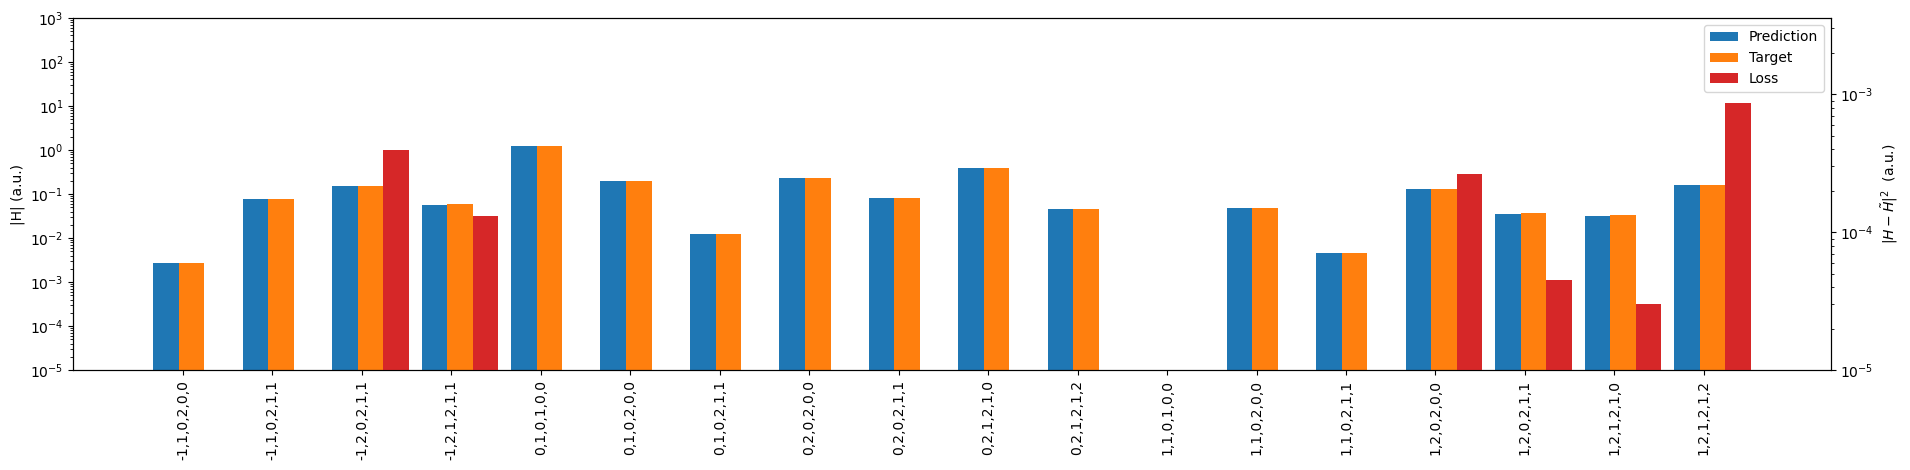

In [81]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks, pred_ridge_bias, plot_loss = True)
ax_loss.set_ylim(1e-5,)
ax.set_ylim(1e-5,)
fig.tight_layout()

# Train

In [19]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, map_targetkeys_to_featkeys
from mlelec.utils.pbc_utils import precompute_phase, TMap_bloch_sums

In [32]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = features, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True,
                            nhidden = 1, 
                            nlayers = 64,
                            activation = 'SiLU',
                            apply_norm = True
                           )
model = model.double()

nepoch = 1000

In [24]:
# optimizers = []
# schedulers = []
# for i, key in enumerate(model.model):
#     optimizers.append(torch.optim.Adam(model.model[key].parameters(), lr = 5e-4)) #, betas = (0.8, 0.9)))
#     schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers[-1], factor = 0.5, patience = 100))

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #, betas = (0.8, 0.9)))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience = 10)

In [25]:
from metatensor.learn import DataLoader

batch_size = 1
dataloader = DataLoader(ml_data, batch_size = batch_size, shuffle = False, collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))
# dataloader_k = DataLoader(ml_data_k, batch_size = batch_size, shuffle = False, collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))

In [144]:
overnorms = [torch.stack([dataset.fock_realspace[ifr][T]*dataset.overlap_realspace[ifr][T] for T in dataset.fock_realspace[ifr]]).sum() for ifr in range(len(dataset))]

In [26]:
from mlelec.metrics import Eigval_loss
loss_fn = Eigval_loss #L2_loss #_meanzero

In [27]:
from mlelec.utils.twocenter_utils import lowdin_orthogonalize

In [ ]:
HT = blocks_to_matrix(pred, dataset, detach = False)

In [28]:
# %%timeit -n 1 -r 1

train_kspace = False
LOSS_LIST = []

lr = scheduler.get_last_lr()

nepoch = 500
for epoch in range(nepoch):

    # Train against real space targets
    LOSS = 0
    # lr = []
    for ib, batch in enumerate(dataloader):
        
        model.train(True)
        
        # for ik, key in enumerate(model.model):
            # optimizers[ik].zero_grad()
        optimizer.zero_grad()
        
        pred = model.predict_batch(batch.descriptor, batch.target)
        HT = blocks_to_matrix(pred, dataset, detach = False)
        HK = dataset.bloch_sum(HT)[batch.sample_id[0]] + batch.baseline
        pred_eigvals = torch.stack([torch.linalg.eigvalsh(lowdin_orthogonalize(h, s)) for h, s in zip(HK, batch.overlap_kpoints)])

        loss = loss_fn(pred_eigvals, batch.eigenvalues)
       
        LOSS += loss.item()

        loss.backward() #retain_graph = False)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        scheduler.step(loss)
        if not np.isclose(scheduler.get_last_lr(), lr):
            lr = scheduler.get_last_lr()
            print(f'lr changed to {lr}')
  
    if epoch >= 0: #% 10 == 0:
        # print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        # print(f"Epoch {epoch:>7d}, train loss real {loss_real[-1]:>15.10f}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        LOSS_LIST.append(LOSS)
        print(f"Epoch {epoch:>7d}, train loss {LOSS:>15.10f}, avg lr = {np.mean(lr)}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

KeyboardInterrupt: 

In [155]:
model.forward()

TensorMap with 18 blocks
keys: block_type  species_i  n_i  l_i  species_j  n_j  l_j  L
          -1          6       1    0       6       2    0   0
          -1          6       1    0       6       2    1   1
          -1          6       2    0       6       2    1   1
          -1          6       2    1       6       2    1   1
          0           6       1    0       6       1    0   0
          0           6       1    0       6       2    0   0
          0           6       1    0       6       2    1   1
          0           6       2    0       6       2    0   0
          0           6       2    0       6       2    1   1
          0           6       2    1       6       2    1   0
          0           6       2    1       6       2    1   2
          1           6       1    0       6       1    0   0
          1           6       1    0       6       2    0   0
          1           6       1    0       6       2    1   1
          1           6       2    0       6 

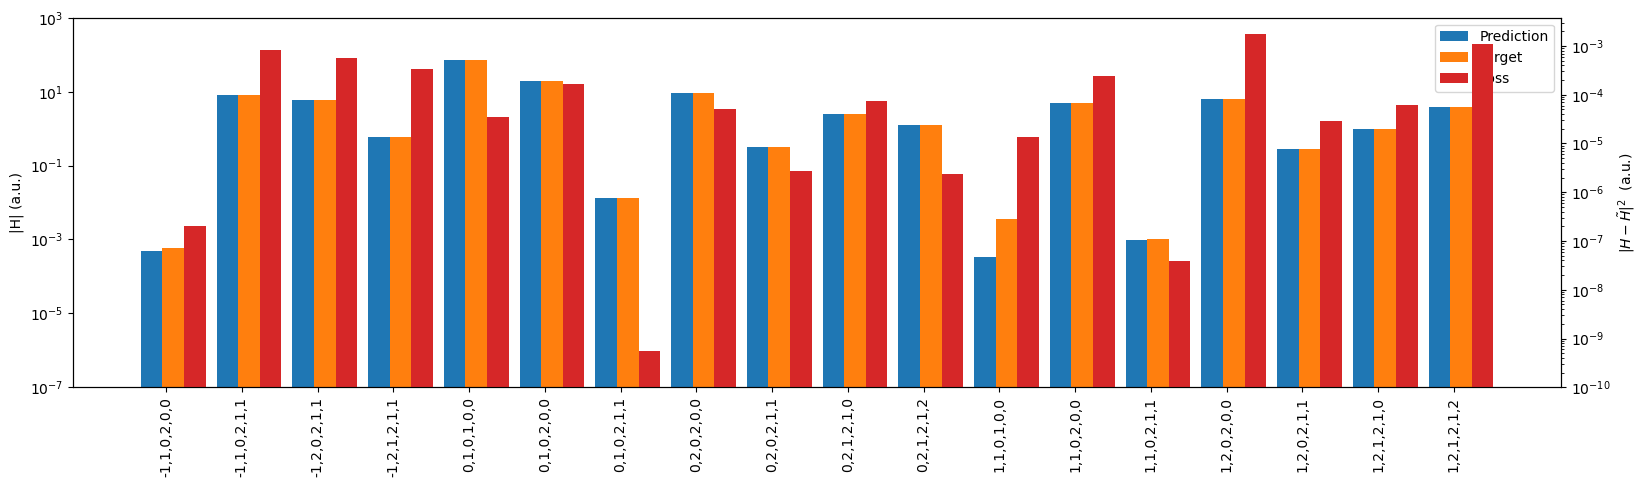

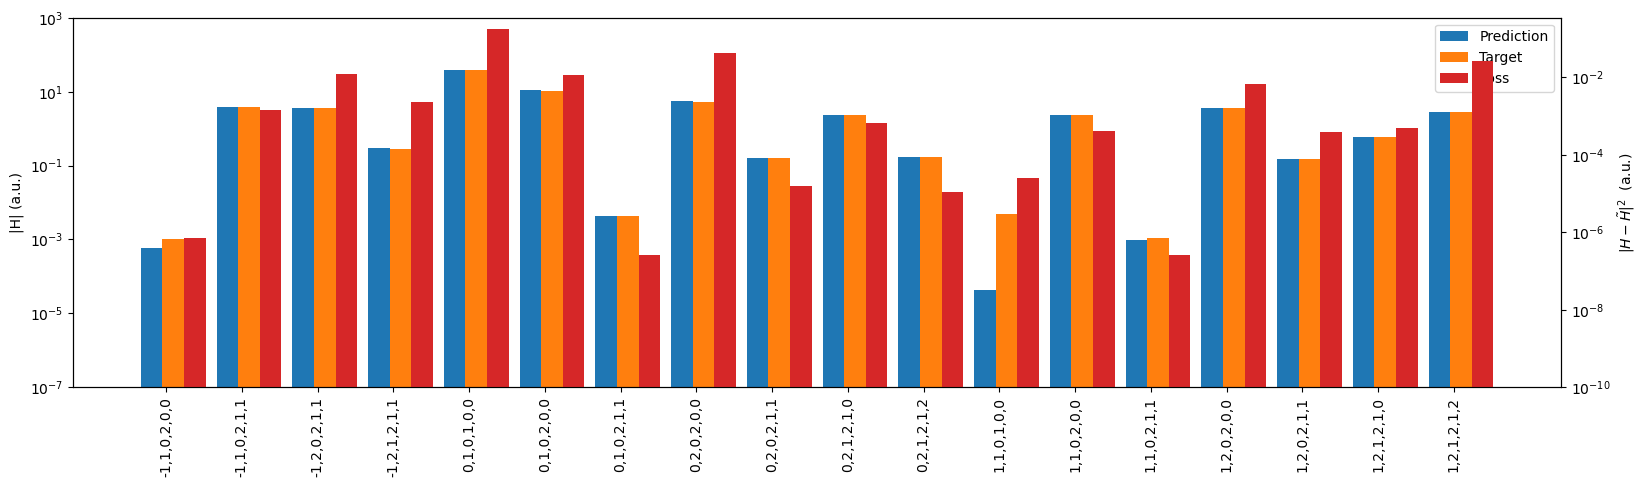

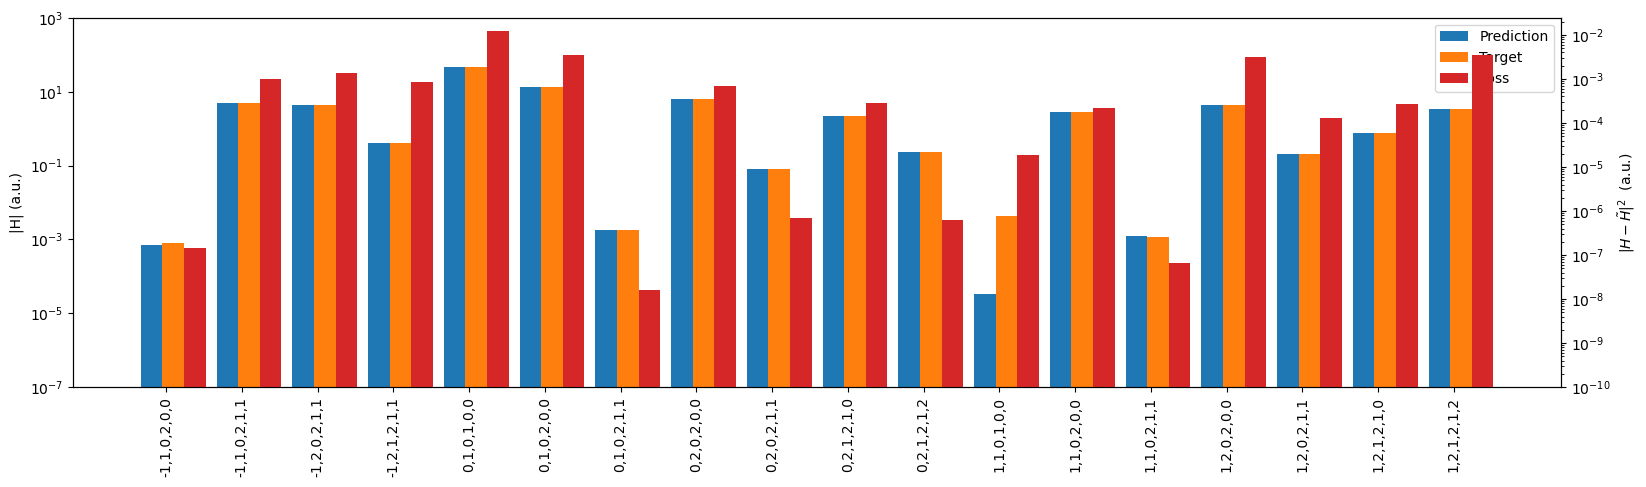

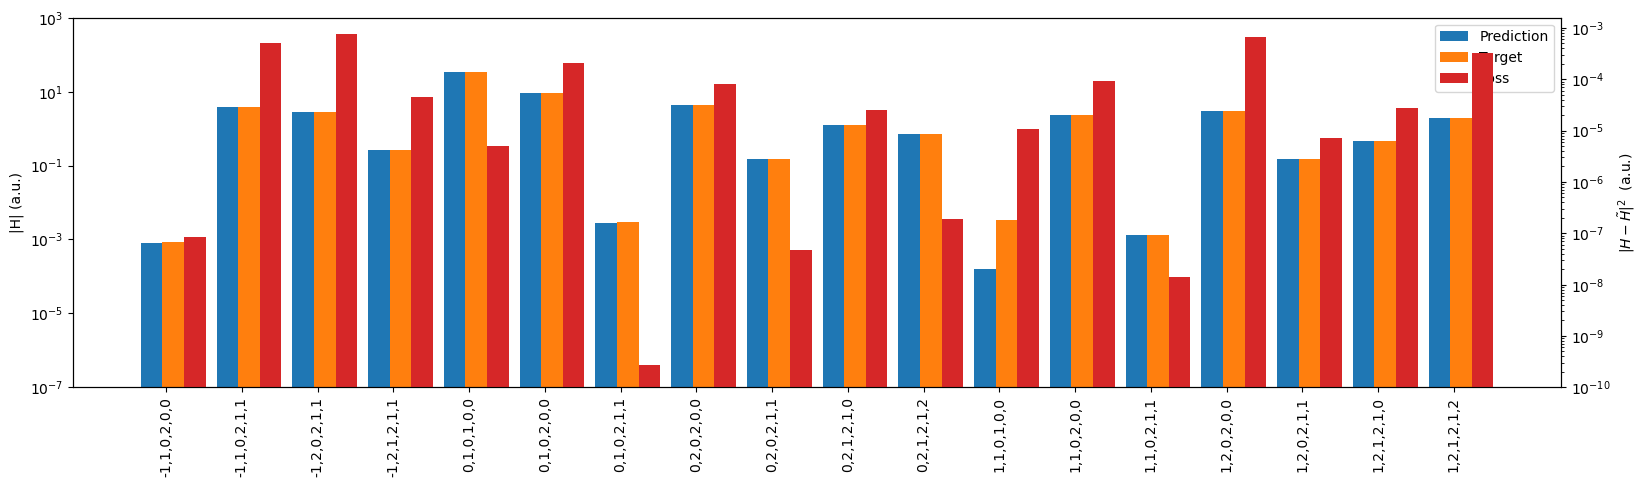

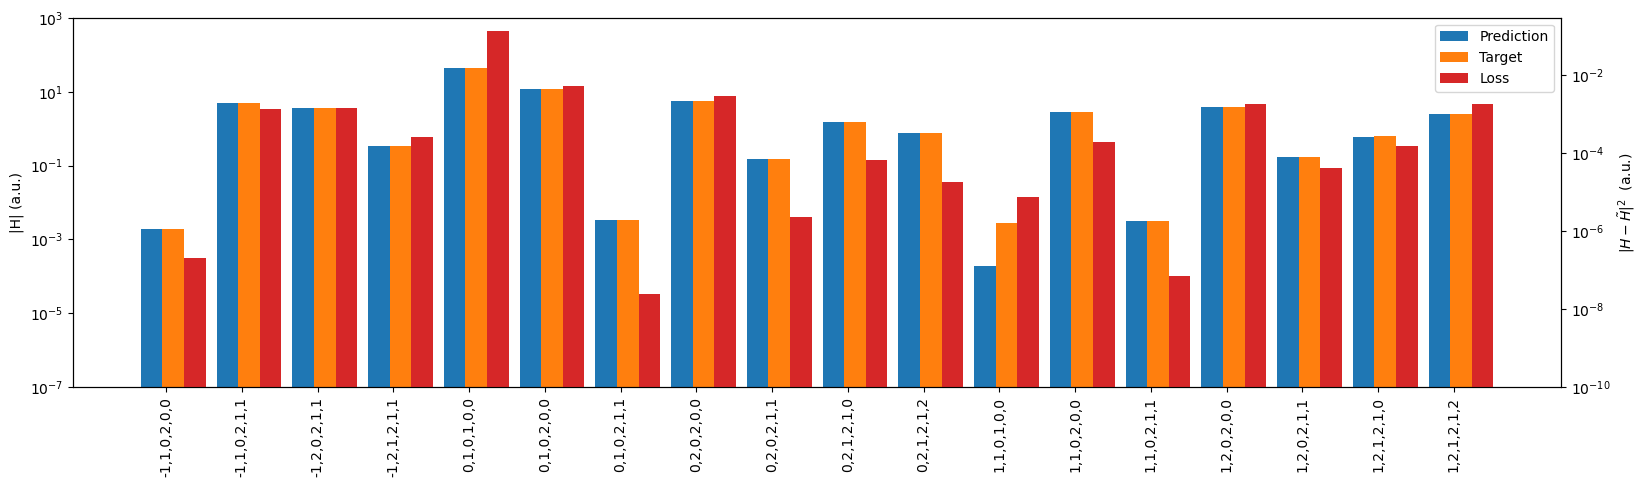

In [241]:
# pred = model.predict_batch(batch.descriptor)
for ib, batch in enumerate(dataloader):
    pred = model.predict_batch(batch.descriptor, batch.target)
    plot_block_errors(pred, batch.target, plot_loss=True)

In [88]:
pred = model()

(<Figure size 1920x480 with 2 Axes>,
 <Axes: ylabel='|H| (a.u.)'>,
 <Axes: ylabel='$|H-\\tilde{H}|^2$  (a.u.)'>)

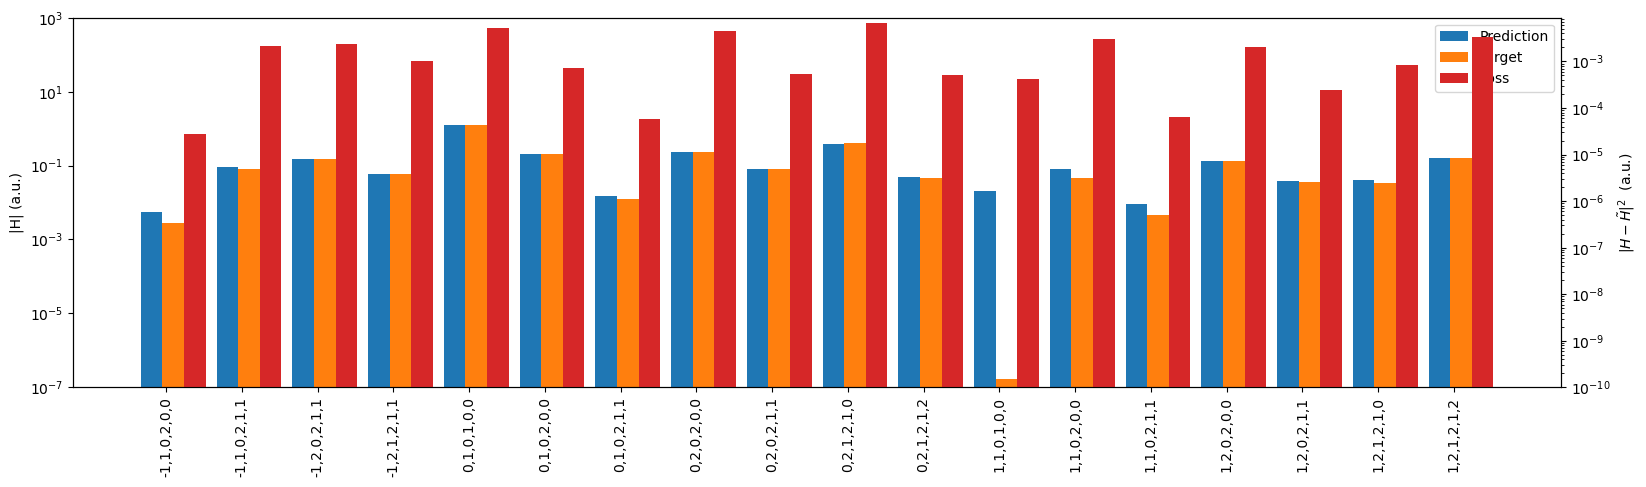

In [91]:
plot_block_errors(target_coupled_blocks, pred, plot_loss=True)

# Test

In [262]:
pred = model()

In [263]:
recon_HT = blocks_to_matrix(pred, dataset)
recon_Hk = dataset.bloch_sum(recon_HT)

In [264]:
overlaps_cutoff = dataset.bloch_sum(blocks_to_matrix(matrix_to_blocks(dataset, cutoff = cutoff, target='overlap'), dataset))
fock_cutoff = dataset.bloch_sum(blocks_to_matrix(matrix_to_blocks(dataset, cutoff = cutoff), dataset))

In [265]:
from scipy.linalg import eigvalsh

eigvals_target = {}
eigvals_pred = {}

for A in range(len(dataset)):

    eigvals_target[A] = []
    eigvals_pred[A] = []
    
    for ik in range(len(dataset.fock_kspace[A])):
        # eigvals_target[A].append(eigvalsh(dataset.fock_kspace[A][ik].numpy(), dataset.overlap_kspace[A][ik].numpy()))

        # Target
        e = eigvalsh(fock_cutoff[A][ik].numpy(), overlaps_cutoff[A][ik].numpy())
        eigvals_target[A].append(e)
        
        # eigvals_target[A].append(e - e[0])
        e = eigvalsh(recon_Hk[A][ik].detach().numpy(), overlaps_cutoff[A][ik].numpy())
        eigvals_pred[A].append(e)
        # eigvals_pred[A].append(e - e[0])

0, 117: RMSE=0.326 a.u.
1, 119: RMSE=3.208 a.u.
2, 120: RMSE=1.591 a.u.
3, 122: RMSE=0.722 a.u.
4, 127: RMSE=2.281 a.u.


Text(0, 0.5, 'Predicted eigenvalues (a.u.)')

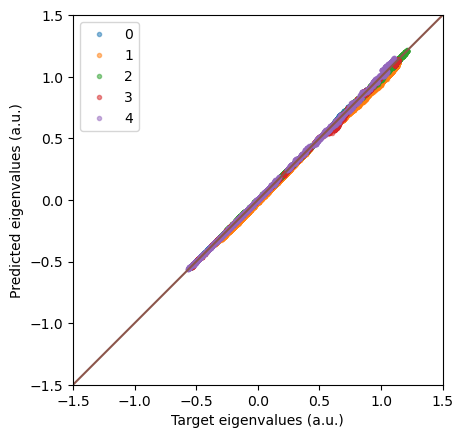

In [266]:
fig, ax = plt.subplots()

ax.set_aspect('equal')

for A in eigvals_target:
    # if A != 2:
    if True:
        x, y = np.concatenate(eigvals_target[A]), np.concatenate(eigvals_pred[A])
        print(f'{A}, {indices[A]}: RMSE={np.sqrt(np.linalg.norm(x-y)**2):.3f} a.u.')
        plt.plot(x, y, '.', alpha = 0.5, label = A)
ax.legend(loc = 'upper left')

ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)

# ax.set_xlim(-9.6,-9)
# ax.set_ylim(-9.6,-9)

ax.plot([-10,1.5], [-10,1.5])

ax.set_xlabel('Target eigenvalues (a.u.)')
ax.set_ylabel('Predicted eigenvalues (a.u.)')

0, 117: RMSE=0.209 a.u.
1, 119: RMSE=4.763 a.u.
2, 120: RMSE=1.386 a.u.
3, 122: RMSE=0.579 a.u.
4, 127: RMSE=2.151 a.u.


Text(0, 0.5, 'Predicted eigenvalues (a.u.)')

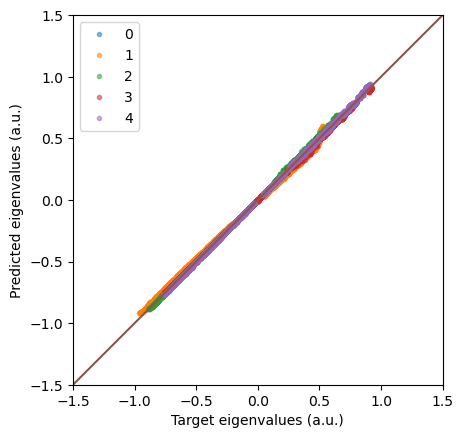

In [249]:
fig, ax = plt.subplots()

ax.set_aspect('equal')

for A in eigvals_target:
    # if A != 2:
    if True:
        x, y = np.concatenate(eigvals_target[A]), np.concatenate(eigvals_pred[A])
        print(f'{A}, {indices[A]}: RMSE={np.sqrt(np.linalg.norm(x-y)**2):.3f} a.u.')
        plt.plot(x, y, '.', alpha = 0.5, label = A)
ax.legend(loc = 'upper left')

ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)

# ax.set_xlim(-9.6,-9)
# ax.set_ylim(-9.6,-9)

ax.plot([-10,1.5], [-10,1.5])

ax.set_xlabel('Target eigenvalues (a.u.)')
ax.set_ylabel('Predicted eigenvalues (a.u.)')

## Load pretrained model

In [183]:
# checkpoint = torch.load('/home/pegolo/Software/mlelec/examples/data/periodic/deepH_graphene/models/model_1500.ckpt')
checkpoint = torch.load('/home/pegolo/Downloads/model_allo_meanzero.cptk')

In [149]:
allo_checkpoint = torch.load('./examples/data/periodic/carbon_allotropes/allotropes_model_1700.ckpt')

In [131]:
from mlelec.models.linear import LinearModelPeriodic
graphene_model = LinearModelPeriodic(twocfeat = features, 
                                     target_blocks = target_coupled_blocks,
                                     frames = dataset.structures, orbitals = dataset.basis, 
                                     device = device,
                                     bias = True,
                                     nhidden = 128, 
                                     nlayers = 2,
                                     activation = 'SiLU',
                                     apply_norm = True)
graphene_model = graphene_model.double()

In [195]:
from mlelec.models.linear import LinearModelPeriodic
allo_model = LinearModelPeriodic(twocfeat = fea, 
                                 target_blocks = tcb,
                                     frames = dataset.structures, orbitals = dataset.basis, 
                                     device = device,
                                     bias = True,
                                     nhidden = 64, 
                                     nlayers = 1,
                                     activation = 'SiLU',
                                     apply_norm = True)
allo_model = allo_model.double()

In [196]:
allo_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [197]:
pred_from_allo = allo_model.predict(fea, tcb)

In [201]:
from mlelec.metrics import L2_loss, L2_loss_meanzero
loss_fn = L2_loss

In [202]:
L2_loss(pred_from_allo, tcb)

tensor(32.6739, grad_fn=<AddBackward0>)

(<Figure size 1920x480 with 2 Axes>,
 <Axes: ylabel='|H| (a.u.)'>,
 <Axes: ylabel='$|H-\\tilde{H}|^2$  (a.u.)'>)

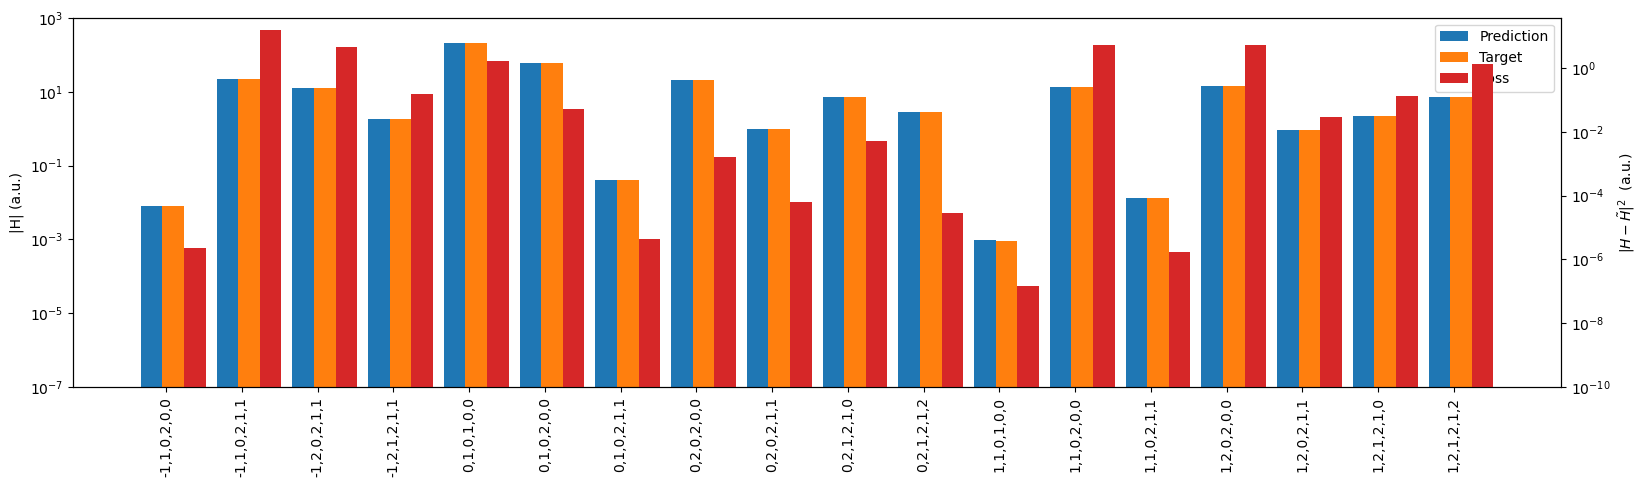

In [203]:
# pred = model()
plot_block_errors(tcb, pred_from_allo, plot_loss=True)

In [209]:
tot = 0
for (k, p), t in zip(pred_from_allo.items(), tcb.blocks()):
    print(k.values)
    print(f'|p|={p.values.norm().item():.5f} |t|={t.values.norm().item():.5f}')
    print(f'|p-t|={(p.values-t.values).norm().item():.5f}')
    tot += (p.values-t.values).norm().item()
print(tot)

tensor([-1,  6,  1,  0,  6,  2,  0,  0], dtype=torch.int32)
|p|=0.00789 |t|=0.00782
|p-t|=0.00149
tensor([-1,  6,  1,  0,  6,  2,  1,  1], dtype=torch.int32)
|p|=22.41940 |t|=22.43368
|p-t|=3.82454
tensor([-1,  6,  2,  0,  6,  2,  1,  1], dtype=torch.int32)
|p|=12.84445 |t|=12.85746
|p-t|=2.10067
tensor([-1,  6,  2,  1,  6,  2,  1,  1], dtype=torch.int32)
|p|=1.77662 |t|=1.81900
|p-t|=0.38522
tensor([0, 6, 1, 0, 6, 1, 0, 0], dtype=torch.int32)
|p|=211.84574 |t|=212.16556
|p-t|=1.28828
tensor([0, 6, 1, 0, 6, 2, 0, 0], dtype=torch.int32)
|p|=58.35847 |t|=58.39658
|p-t|=0.22609
tensor([0, 6, 1, 0, 6, 2, 1, 1], dtype=torch.int32)
|p|=0.03992 |t|=0.03996
|p-t|=0.00206
tensor([0, 6, 2, 0, 6, 2, 0, 0], dtype=torch.int32)
|p|=20.71169 |t|=20.71590
|p-t|=0.04033
tensor([0, 6, 2, 0, 6, 2, 1, 1], dtype=torch.int32)
|p|=0.95108 |t|=0.95114
|p-t|=0.00805
tensor([0, 6, 2, 1, 6, 2, 1, 0], dtype=torch.int32)
|p|=7.23527 |t|=7.24206
|p-t|=0.07104
tensor([0, 6, 2, 1, 6, 2, 1, 2], dtype=torch.int32)
|p|=

In [210]:
recon_HT = blocks_to_matrix(pred_from_allo, dataset)

In [211]:
recon_Hk = dataset.bloch_sum(recon_HT)

In [212]:
cutoff_overlaps = blocks_to_matrix(matrix_to_blocks(dataset, cutoff = cutoff, target='overlap'), dataset)

In [213]:
recon_Sk = dataset.bloch_sum(cutoff_overlaps)

In [214]:
from scipy.linalg import eigvalsh
eigvals_target = {}
eigvals_pred = {}
for A in range(len(dataset)):
    eigvals_target[A] = []
    eigvals_pred[A] = []
    for ik in range(len(dataset.fock_kspace[A])):
        eigvals_target[A].append(eigvalsh(dataset.fock_kspace[A][ik].numpy(), dataset.overlap_kspace[A][ik].numpy()))
        eigvals_pred[A].append(eigvalsh(recon_Hk[A][ik].detach().numpy(), recon_Sk[A][ik].detach().numpy()))

In [294]:
view(dataset.structures)

<Popen: returncode: None args: ['/home/pegolo/micromamba/envs/sci/bin/python...>

0, 117: RMSE=0.083 a.u.
1, 119: RMSE=2.358 a.u.
2, 120: RMSE=0.736 a.u.
3, 122: RMSE=0.102 a.u.
4, 127: RMSE=0.178 a.u.
5, 132: RMSE=0.186 a.u.
6, 138: RMSE=0.026 a.u.
7, 160: RMSE=2.307 a.u.
8, 162: RMSE=17.255 a.u.
9, 165: RMSE=0.096 a.u.
10, 180: RMSE=0.062 a.u.
11, 188: RMSE=2.500 a.u.
12, 189: RMSE=0.101 a.u.
13, 207: RMSE=3.603 a.u.
14, 221: RMSE=6.094 a.u.
15, 223: RMSE=2.438 a.u.
16, 232: RMSE=0.125 a.u.
17, 244: RMSE=1.730 a.u.
18, 270: RMSE=3.200 a.u.
19, 273: RMSE=2.169 a.u.


(-2.0, 2.0)

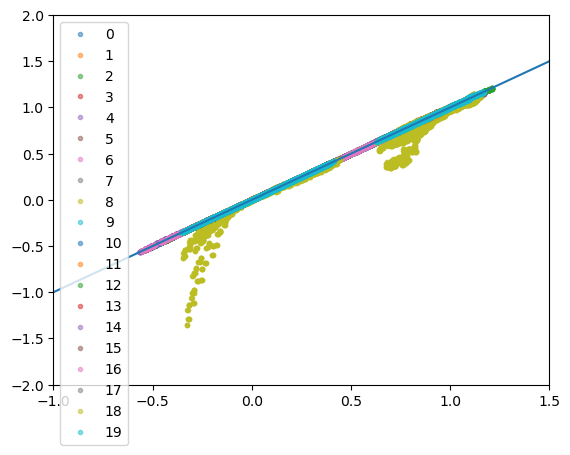

In [219]:
for A in eigvals_target:
    # if A != 2:
    if True:
        x, y = np.concatenate(eigvals_target[A]), np.concatenate(eigvals_pred[A])
        print(f'{A}, {indices[A]}: RMSE={np.sqrt(np.linalg.norm(x-y)**2):.3f} a.u.')
        plt.plot(x, y, '.', alpha = 0.5, label = A)
plt.plot([-11,2], [-11,2])
# plt.plot([-1,2], [-1,2])
plt.legend()
# plt.xlim(-9.78,-9.7)
# plt.ylim(-9.78,-9.7)
plt.xlim(-1,1.5)
plt.ylim(-2,2)

In [218]:
view(dataset.structures)

<Popen: returncode: None args: ['/home/pegolo/micromamba/envs/sci/bin/python...>

[]

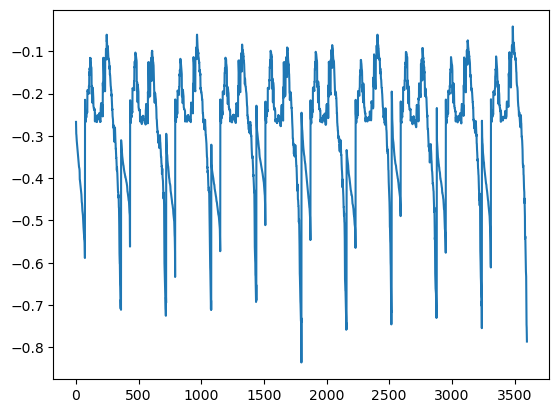

In [162]:
plt.plot(np.concatenate(eigvals_target) - np.concatenate(eigvals_pred))
plt.plot()

In [147]:
view(frames)

<Popen: returncode: None args: ['/home/pegolo/micromamba/envs/sci/bin/python...>

# Meh

In [59]:
split_features, split_target = split_by_Aij(target_coupled_blocks, features = features)

## Using tensormaps

In [65]:
split_features, split_target = split_by_Aij_mts(target_coupled_blocks, features = features)

In [66]:
ml_data = IndexedDataset(descriptor = list(split_features.values()), target = list(split_target.values()), sample_id = list(split_target.keys()))

In [111]:
batch_size = 20
dataloader = DataLoader(ml_data, batch_size = batch_size, shuffle = True, collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))

In [92]:
phase, indices, kpts_idx = precompute_phase(target_coupled_blocks, dataset, cutoff = cutoff)

In [112]:
kmap = []
for batch in dataloader:
    kmap.append(TMap_bloch_sums(batch.target, phase, indices, kpts_idx, return_tensormap = True))

## Check target and features decay

In [165]:
from mlelec.utils.plot_utils import block_matrix_norm, matrix_norm

In [179]:
rij, Hij = block_matrix_norm(tcb, dataset)

In [180]:
rij_S, Sij = block_matrix_norm(ocb, dataset)

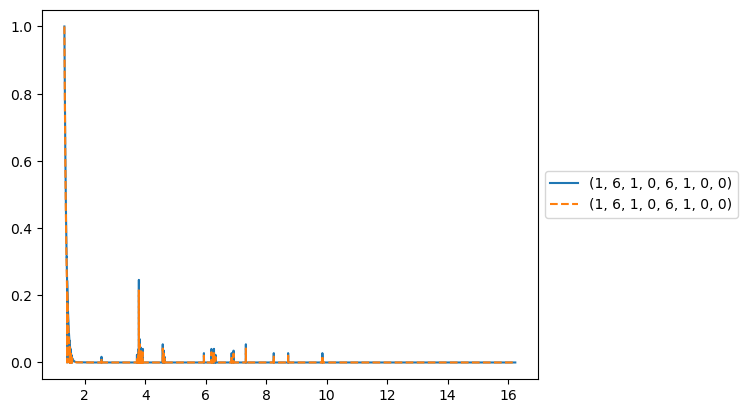

In [181]:
for k in rij:
    if k[0] == 1 and k[-1]==0 and k[3]==0 and k[5]==1:
        x = np.array(rij[k])
        y = np.array(Hij[k])[x.argsort()]
        plt.plot(x[x.argsort()], y/y[0], '-', label = k)

        x = np.array(rij_S[k])
        y = np.array(Sij[k])[x.argsort()]
        plt.plot(x[x.argsort()], y/y[0], '--', label = k)
# plt.ylim(-1e-3,1)
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))

In [94]:
rij_, fij = block_matrix_norm(features, dataset)

In [260]:
from rascaline import SphericalExpansionByPair
from mlelec.features.acdc_utils import acdc_standardize_keys
gij = SphericalExpansionByPair(**hypers_pair).compute(frames)
gij = acdc_standardize_keys(gij)
rij_, fij = block_matrix_norm(gij, dataset)

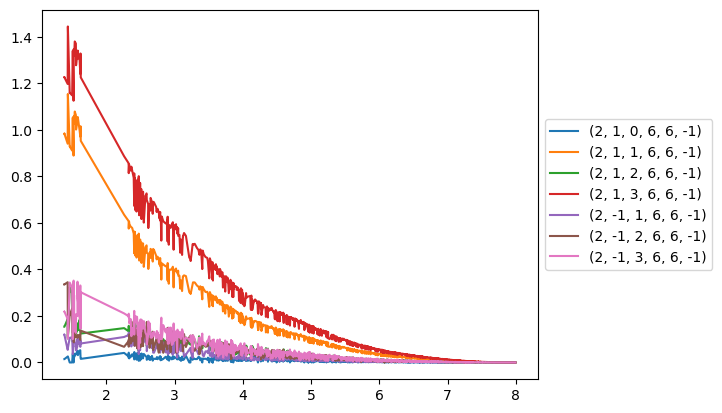

In [96]:
for k in rij_:
    # if k[0] == 1 and k[-1]==0 and k[3]==0 and k[5]==1:
    if k[-1]==-1:
    
        x = np.array(rij_[k])
        y = np.array(fij[k])
        plt.plot(x[x.argsort()], y[x.argsort()], '-', label = k)
# plt.ylim(-1e-3,1)
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))

In [148]:
ht = blocks_to_matrix(target_blocks, dataset)
ht_=[]
for ifr in range(len(rht)):
    ht_.append(torch.stack(list(ht[ifr].values())).flatten())
ht_ = torch.cat(ht_)

In [167]:
from ase.units import Hartree
lossfn = nn.L1Loss()
# lossfn = nn.MSELoss()
lossfn(rht_,ht_)*Hartree*1000

tensor(0.1531)

## Debug samples mismatch

In [65]:
pred = model()

Check metadata

In [68]:
assert mts.equal_metadata(pred, target_coupled_blocks)

Check keys

In [69]:
target_coupled_blocks

TensorMap with 18 blocks
keys: block_type  species_i  n_i  l_i  species_j  n_j  l_j  L
          -1          6       1    0       6       2    0   0
          -1          6       1    0       6       2    1   1
          -1          6       2    0       6       2    1   1
          -1          6       2    1       6       2    1   1
          0           6       1    0       6       1    0   0
          0           6       1    0       6       2    0   0
          0           6       1    0       6       2    1   1
          0           6       2    0       6       2    0   0
          0           6       2    0       6       2    1   1
          0           6       2    1       6       2    1   0
          0           6       2    1       6       2    1   2
          1           6       1    0       6       1    0   0
          1           6       1    0       6       2    0   0
          1           6       1    0       6       2    1   1
          1           6       2    0       6 